In [ ]:
!pip install pydoe
!gdown --id 1O1k57hOipLRHW1icIZEFFm31dGaEFsQa -O model_utils.py
!gdown --id 1-t4mOfZvlEVgexAe5PM7FCrfzXgWPkVz -O pwlf_mod.py

Downloading...
From: https://drive.google.com/uc?id=1O1k57hOipLRHW1icIZEFFm31dGaEFsQa
To: /content/model_utils.py
100% 34.5k/34.5k [00:00<00:00, 48.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-t4mOfZvlEVgexAe5PM7FCrfzXgWPkVz
To: /content/pwlf_mod.py
100% 62.2k/62.2k [00:00<00:00, 52.6MB/s]


In [128]:
import model_utils as mu
mu.DEATH_RATE = 0.36
mu.ICU_RATE = 0.78
mu.HOSPITAL_RATE = 2.18
mu.SYMPTOM_RATE = 10.2
mu.INCUBATE_TIME = 4
mu.INFECT_2_HOSPITAL_TIME = 11
mu.HOSPITAL_2_ICU_TIME = 4
mu.ICU_2_DEATH_TIME = 4
mu.ICU_2_RECOVER_TIME = 7
mu.NOT_ICU_DISCHARGE_TIME = 5
mu.REPORT_RATE = 0.67

In [2]:
import pandas as pd
import numpy as np
import pwlf_mod as pwlf
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
#Use plotly
import plotly.offline as py_offline
import cufflinks as cf
cf.go_offline()
py_offline.__PLOTLY_OFFLINE_INITIALIZED = True

In [4]:
# Add for Google Colab
import plotly
plotly.io.renderers.default = 'colab'

In [4]:
import imp; imp.reload(mu)

<module 'model_utils' from '/home/quoc/github/Covid19_VN/model_utils.py'>

In [5]:
sheet_url = "https://docs.google.com/spreadsheets/d/1iviYd0Cha8K2bHkVTtSwyo9fxrusqaMfm6QP-Iw75Eg/edit#gid=0"
sheet_url = "https://docs.google.com/spreadsheets/d/1itEerwNBiPovo3yiTiFcAnxZMQ6YUSZ_Wps_jfShs3Q/export?format=csv"

In [67]:
def get_data_vn(sheet_url = "https://docs.google.com/spreadsheets/d/1itEerwNBiPovo3yiTiFcAnxZMQ6YUSZ_Wps_jfShs3Q/export?format=csv"):
    url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
    data = pd.read_csv(url_1).set_index('date')
    data.index = pd.to_datetime(data.index)
    return data
def get_data_vn_by_province(province, district='All', type='deaths'):
    vn_data = get_data()
    if district == 'All':
        local_data = vn_data.query('Tinh == "{}"'.format(province)).iloc[:, :].T.sum(axis=1).to_frame()
    else:
        local_data = US_data.query('Tinh == "{}" and Huyen == "{}"'.format(province, district))\
                         .iloc[:, :].T.sum(axis=1).to_frame()
    return local_data

In [164]:
def get_avg_data(data, smoothing_days=7, col_suffix='_avg'):
    data_avg = data.rolling(smoothing_days, min_periods=3).mean()
    # Turn 0 to nan to avoid log of 0
    data_avg[data_avg <= 0.01] = np.nan
    data_avg.columns = data_avg.columns + col_suffix
    return data_avg

In [165]:
def get_transformed_data(data, smoothing_days=7):
    return np.log(get_avg_data(data))

In [173]:
def predict(data, forecast_horizon=30, policy_effective_dates=[], smoothing_days=7,  effective_rate=0.8):
    '''Since this is highly contagious disease. Daily new death, which is a proxy for daily new infected cases
    is model as d(t)=a*d(t-1) or equivalent to d(t) = b*a^(t). After a log transform, it becomes linear.
    log(d(t))=logb+t*loga, so we can use linear regression to provide forecast (use robust linear regressor to avoid
    data anomaly in death reporting)
    There are two separate linear curves, one before the lockdown is effective(21 days after lockdown) and one after
    For using this prediction to infer back the other metrics (infected cases, hospital, ICU, etc..) only the before
    curve is used and valid. If we assume there is no new infection after lock down (perfect lockdown), the after
    curve only depends on the distribution of time to death since ICU.
    WARNING: if lockdown_date is not provided, we will default to no lockdown to raise awareness of worst case
    if no action. If you have info on lockdown date please use it to make sure the model provide accurate result'''
    #for policy_effective_date in policy_effective_dates:
    #    data = data.loc[
    #        (data.index > policy_effective_date + dt.timedelta(smoothing_days)) |
    #        (data.index <= policy_effective_date)]

    # log_daily_death.dropna(inplace=True)
    data_start_date = min(data.index)
    data_end_date = max(data.index)
    forecast_end_date = data_end_date + dt.timedelta(forecast_horizon)
    forecast_date_index = pd.date_range(start=data_start_date, end=forecast_end_date)

    data_start_date_idx = 0
    data_end_date_idx = (data_end_date - data_start_date).days
    forecast_end_date_idx = data_end_date_idx + forecast_horizon
    forecast_time_idx = (forecast_date_index - data_start_date).days.values
    data_time_idx = (data.index - data_start_date).days.values
    policy_effective_dates_idx = (policy_effective_dates - data_start_date).days.values
    data['time_idx'] = data_time_idx
    #import pdb; pdb.set_trace()
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    break_points = np.array([data_start_date_idx, ] +
                            policy_effective_dates_idx[(~np.isnan(policy_effective_dates_idx))&
                                                       (policy_effective_dates_idx < forecast_end_date_idx)].tolist() +
                            [forecast_end_date_idx, ])
    regr_pw = pwlf.PiecewiseLinFit(x=data.time_idx.values, y=data.iloc[:,0])
    regr_pw.fit_with_breaks(break_points)
    model_beta = regr_pw.beta
    log_predicted_var = smoothing_days * regr_pw.prediction_variance(forecast_time_idx)

    # Use default slope when data is not enough to fit last line, less than 4 data point, with contain_rate=1 mean slope
    # is the same as previous slope (same policy) and 0 mean (relax 100%) slope will be same as before lockdown

    if ((data_end_date_idx-break_points[-2]) < 4) | (model_beta[-1] > max(0.3, abs(model_beta[1]))):
        if model_beta[-2] < 0:
            model_beta[-1] = model_beta[-2]*effective_rate
        else:
            model_beta[-1] = (-model_beta[-2])*(1+effective_rate)
        print("Use default last slope due to not enough data")
        #import pdb; pdb.set_trace()
        variance = log_predicted_var[sum(forecast_time_idx <= break_points[-2])]
        log_predicted_var_oos = variance * (forecast_time_idx[forecast_time_idx > break_points[-2]] -
                                                       break_points[-2])
        log_predicted_var = np.concatenate(
                (log_predicted_var[:sum(forecast_time_idx <= break_points[-2])],
                 log_predicted_var_oos))

    log_predicted_values = regr_pw.predict(forecast_time_idx, beta=model_beta, breaks=break_points)

    log_predicted_lower_bound_values = log_predicted_values - 1.96 * np.sqrt(log_predicted_var)
    log_predicted_upper_bound_values = log_predicted_values + 1.96 * np.sqrt(log_predicted_var)

    log_predicted = pd.DataFrame(log_predicted_values, index=forecast_date_index)
    log_predicted_lower_bound = pd.DataFrame(log_predicted_lower_bound_values, index=forecast_date_index)
    log_predicted_upper_bound = pd.DataFrame(log_predicted_upper_bound_values, index=forecast_date_index)
    log_predicted.columns = ['predicted']
    log_predicted_lower_bound.columns = ['lower_bound']
    log_predicted_upper_bound.columns = ['upper_bound']
    return pd.concat([log_predicted, log_predicted_lower_bound, log_predicted_upper_bound], axis=1, sort=True), regr_pw.beta


In [174]:
def get_infected_cases_from_symptom_cases(symptom_cases, col_suffix='_infected'):
    '''This number only is close to number of confirmed case in country very early in the disease and 
    can still do contact tracing or very wide testing, eg. South Korea, Germany'''
    delay_time = mu.INFECT_2_HOSPITAL_TIME - mu.INCUBATE_TIME
    infected_cases = (100/mu.SYMPTOM_RATE/mu.REPORT_RATE)*symptom_cases.tshift(-delay_time)
    infected_cases.columns = infected_cases.columns + col_suffix
    return infected_cases


In [220]:
def get_metrics_VN(province='TpHCM', district='All', forecast_horizon=30, policy_change_dates=[], effective_rate=0.8,
                            test_rate=0.2, back_test=False, last_data_date=dt.date.today()):

    data = get_data_vn()
    data_orig = data.copy()
    if back_test:
        data = data[data.index.date <= last_data_date]
    log_data = get_transformed_data(data).iloc[4:]
    policy_effective_dates = pd.to_datetime(policy_change_dates) + dt.timedelta(
            mu.INFECT_2_HOSPITAL_TIME)
    predicted_log_f0_community, beta = predict(log_data[['f0_community_avg']], policy_effective_dates=policy_effective_dates, effective_rate=effective_rate)
    log_f0 = pd.concat([predicted_log_f0_community, log_data], axis=1, sort=True)
    log_f0_ve = log_f0.rename(columns={'f0_community_avg': 'Log(F0 tầm soát)', 'predicted': 'Dự báo Log(F0 tầm soát)',
                          'lower_bound': 'Cận dưới Log(F0 tầm soát)', 'upper_bound': 'Cận trên Log(F0 tầm soát)', 'f0_avg':'Log(F0)'})\
        .drop(columns=['ICU_current_avg'], errors='ignore')

    f0 = pd.concat([get_infected_cases_from_symptom_cases(np.exp(predicted_log_f0_community)), data_orig, np.exp(predicted_log_f0_community)], axis=1, sort=True)

    f0_ve = f0.rename(columns={'f0_community': 'F0 tầm soát', 'predicted': 'Dự báo F0 tầm soát', 'predicted_infected': 'Dự báo ca thực nhiễm',
                          'lower_bound': 'Cận dưới F0 tầm soát', 'upper_bound': 'Cận trên F0 tầm soát', 'f0':'F0', 'upper_bound_infected': 'Cận trên dự báo ca thực nhiễm',  
                          'lower_bound_infected': 'Cận dưới dự báo ca thực nhiễm'})\
        .drop(columns=['ICU_current'], errors='ignore')

    #if back_test:
    #    f0_ve['F0 tầm soát'] = data_orig['f0_community']
    #    f0_ve['7d_avg_death'] = data_orig.rolling(7, min_periods=3).mean()

    cumulative_f0_ve = f0_ve.drop(columns=['ICU', 'hospital_beds'], errors='ignore').cumsum()
 
    #cumulative_metrics['ICU'] = daily_metrics['ICU']
    #cumulative_metrics['hospital_beds'] = daily_metrics['hospital_beds']
    print('Hệ số lây nhiễm sau khi chỉ thị có hiệu lực, R0 cuối: {last}'.format(last=np.exp(sum(beta[1:]))))
    return log_f0_ve, f0_ve, cumulative_f0_ve, beta


In [221]:
log_f0_ve, f0_ve, cumulative_f0_ve, beta = get_metrics_VN(policy_change_dates =['2021-06-01'])

Hệ số lây nhiễm sau khi chỉ thị có hiệu lực, R0 cuối: 1.071825660966784


In [222]:
log_f0_ve.iplot()

In [223]:
f0_ve.iplot()

In [224]:
cumulative_f0_ve.iplot()


# Kịch  bản 



In [225]:
policy_change_dates_full =['2021-06-01', '2021-06-20']

## Kịch  bản hiệu quả cao

In [229]:
log_f0_ve_kbc, f0_ve_kbc, cumulative_f0_ve_kbc, beta = get_metrics_VN(policy_change_dates = policy_change_dates_full)
print('Hệ số lây nhiễm sau khi chỉ thị có hiệu lực, R0 cuối: {last}'.format(last=np.exp(sum(beta[1:]))))
f0_ve_kbc.iplot(title = "Biểu độ dự báo tình hình lây nhiễm  kịch  bản hiệu quả cao")
log_f0_ve_kbc.iplot(title = "Biểu độ dự báo tình hình lây nhiễm theo Log scale kịch  bản hiệu quả cao")
cumulative_f0_ve_kbc.iplot(title = "Biểu độ dự báo tình hình lây nhiễm - kịch  bản hiệu quả cao")

Use default last slope due to not enough data
Hệ số lây nhiễm sau khi chỉ thị có hiệu lực, R0 cuối: 0.9743550352212069
Hệ số lây nhiễm sau khi chỉ thị có hiệu lực, R0 cuối: 0.9743550352212069


## Kịch  bản hiệu quả thấp

In [228]:
log_f0_ve_kbt, f0_ve_kbt, cumulative_f0_ve_kbt, beta = get_metrics_VN(policy_change_dates = policy_change_dates_full,
                                                                     effective_rate=0.3)
#print('Hệ số lây nhiễm sau khi chỉ thị có hiệu lực, R0 cuối: {last}'.format(last=np.exp(sum(beta[1:]))))
log_f0_ve_kbt.iplot(title = "Biểu độ dự báo tình hình lây nhiễm theo Log scale kịch  bản hiệu quả thấp ")
f0_ve_kbt.iplot(title = "Biểu độ dự báo tình hình lây nhiễm  kịch  bản hiệu quả thấp ")
cumulative_f0_ve_kbt.iplot(title = "Biểu độ tổng số ca kịch  bản hiệu quả thấp ")

Use default last slope due to not enough data
Hệ số lây nhiễm sau khi chỉ thị có hiệu lực, R0 cuối: 1.0341810049153546


# Tóm tắt

Số  ca lây nhiễm được tầm soát trong cộng đồng cho thấy mức độ lây nhiễm thực sự của Covid19 ở TP

Với cùng một chính sách giãn cách xã hội, đường logarithm của số ca lây nhiễm được tầm soát trong cộng đồng là đường thẳng, ta tạm gọi là "đường lây nhiễm". 

Đường lây nhiễm này thay đổi 11 ngày sau khi một chính sách mới có hiệu lực. 11 ngày là số ngày từ lúc bắt đầu nhiễm đến lúc có triệu chứng rõ rệt phải đi khám ở bệnh viện.

Sau khi TP thực hiện chỉ thị 15+ 16 (Gò Vấp, Q12) ngày 1/6, đường lây nhiễm có thay đổi kể từ ngày 12/6 nhưng chưa đi xuống

11 ngày sau khi thực hiện chỉ thị 10 của thành phố, đường lây nhiễm này sẽ thay đổi.

Tóm tắt về đường cam và đường xanh 

# Vẽ Biểu Đồ Tối Ưu Cho Report (thay vì Tương Tác)

In [207]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import IPython
%matplotlib inline
IPython.display.set_matplotlib_formats('svg')
pd.plotting.register_matplotlib_converters()

def plotCasesLog(log_f0_ve):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.linewidth': 0.5})
    sns.set_context("notebook", rc={"lines.linewidth": 1.75})
    palette = sns.color_palette("tab10", n_colors=3)
    style_order = ['Log(F0 tầm soát)', 'Dự báo Log(F0 tầm soát)', 'Log(F0)']
    z_order = ['Log(F0)', 'Dự báo Log(F0 tầm soát)', 'Log(F0 tầm soát)']
    sns.lineplot(data=log_f0_ve[z_order], style_order=style_order,
                palette=palette, dashes=True, markers=True)
    plt.fill_between(x=log_f0_ve.index, 
                     y1=log_f0_ve['Cận dưới Log(F0 tầm soát)'], 
                     y2=log_f0_ve['Cận trên Log(F0 tầm soát)'],
                     alpha=0.1, color=palette[1], edgecolor='face')
    ax.set_xlim(xmax=datetime.date(2021, 7, 4))
    #ax.set_ylim(ymin=0)
    ax.set_xlabel('Ngày (theo tuần)')
    ax.set_ylabel('Số ca (theo hàm log)')
    ax.set_title('Biểu đồ dự báo tình hình lây nhiễm', fontsize=18)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0, interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

def plotCases(f0_ve):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.linewidth': 0.5})
    sns.set_context("notebook", rc={"lines.linewidth": 1.75})
    palette = sns.color_palette("tab10", n_colors=4)
    style_order = ['F0 tầm soát', 'Dự báo F0 tầm soát', 'F0', 'Dự báo ca thực nhiễm']
    z_order = ['F0', 'Dự báo F0 tầm soát', 'F0 tầm soát', 'Dự báo ca thực nhiễm']
    sns.lineplot(data=f0_ve[z_order], style_order=style_order,
                palette=palette, dashes=True, markers=True)
    plt.fill_between(x=f0_ve.index, 
                     y1=f0_ve['Cận dưới F0 tầm soát'], 
                     y2=f0_ve['Cận trên F0 tầm soát'],
                     alpha=0.1, color=palette[1], edgecolor='face')
    plt.fill_between(x=f0_ve.index, 
                     y1=f0_ve['Cận dưới dự báo ca thực nhiễm'], 
                     y2=f0_ve['Cận trên dự báo ca thực nhiễm'],
                     alpha=0.1, color=palette[1], edgecolor='face')
    ax.set_xlim(xmax=datetime.date(2021, 7, 4))
    ax.set_ylim(ymin=0, ymax=2000)
    ax.set_xlabel('Ngày (theo tuần)')
    ax.set_ylabel('Số ca')
    ax.set_title('Biểu đồ dự báo tình hình lây nhiễm', fontsize=18)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0, interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))


/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning:


The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning:


The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning:


The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning:


The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.



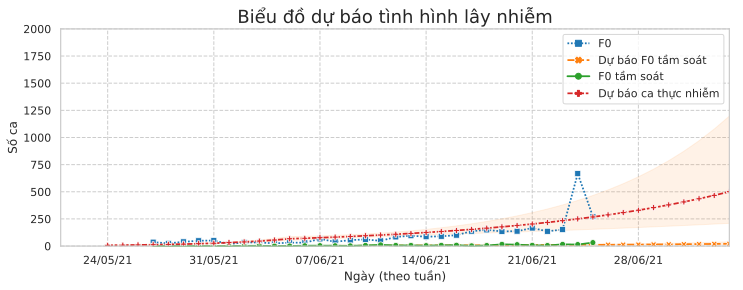

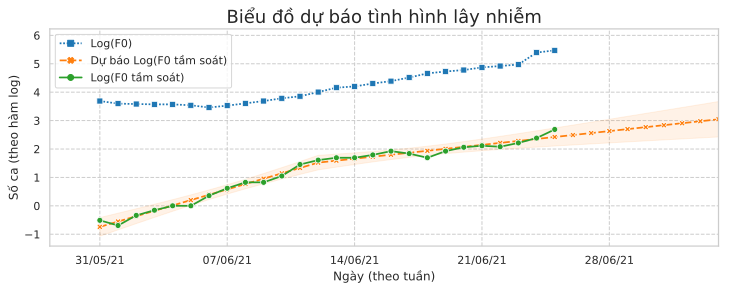

In [208]:
plotCases(f0_ve)
plotCasesLog(log_f0_ve)

### Kịch bản cao

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning:


The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning:


The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning:


The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning:


The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.



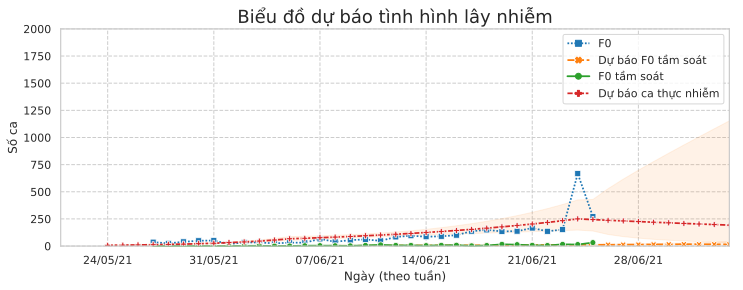

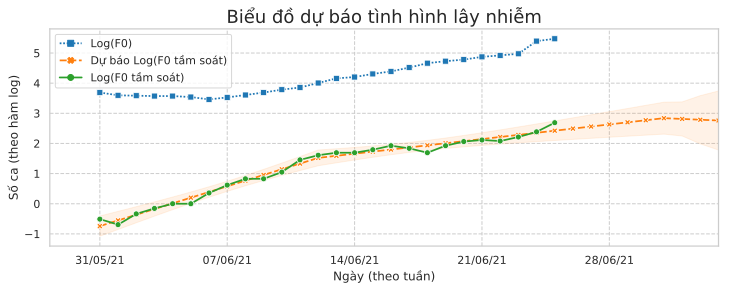

In [209]:
plotCases(f0_ve_kbc)
plotCasesLog(log_f0_ve_kbc)

### Kịch bản thấp

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning:


The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning:


The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning:


The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning:


The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.



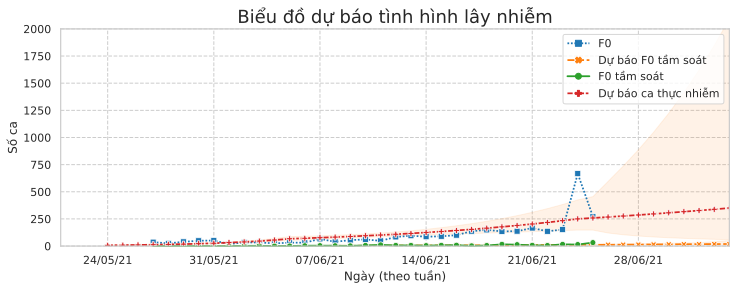

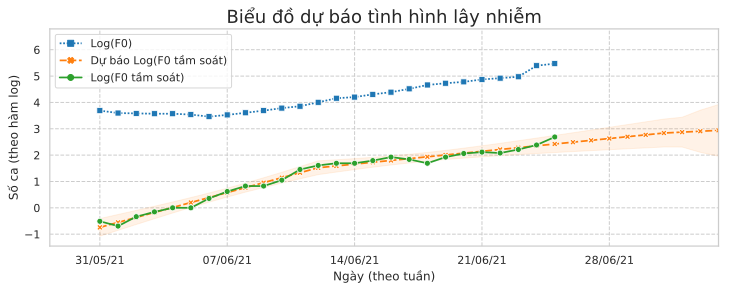

In [210]:
plotCases(f0_ve_kbt)
plotCasesLog(log_f0_ve_kbt)

In [233]:
pd.read_csv("https://docs.google.com/spreadsheets/d/1XmbTAe6D73JQ_JjiqJrpjdn0vxVikm-On_6v7OU44rI/edit?#gid=1033902770")

ParserError: Error tokenizing data. C error: Expected 10 fields in line 8, saw 470


In [236]:
get_data_vn("https://docs.google.com/spreadsheets/d/1XmbTAe6D73JQ_JjiqJrpjdn0vxVikm-On_6v7OU44rI/edit#gid=1033902770")

,f0,f0_community,quan_huyen,tinh_thanh,cong_dong,khu_cach_ly,khu_phong_toa,nhap_canh,trieu_chung
date,,,,,,,,,
2021-05-27,7,2,12,TPHCM,0,7,0,0,6
2021-05-27,2,0,BINH THANH,TPHCM,0,2,0,0,2
2021-05-27,11,0,GO VAP,TPHCM,0,11,0,0,8
2021-05-27,3,1,HOC MON,TPHCM,0,3,0,0,2
2021-05-27,2,0,NHA BE,TPHCM,0,2,0,0,2
...,...,...,...,...,...,...,...,...,...
2021-06-25,2,1,12,TPHCM,2,0,0,0,2
2021-06-25,12,1,8,TPHCM,3,7,2,0,4
2021-06-25,1,0,BINH TAN,TPHCM,0,1,0,0,1
